# Introduction to [JAX](https://github.com/google/jax)

In [1]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def cpu_timer():
    start = default_timer()
    yield
    end = default_timer()
    print(f'Elapsed time: {(end - start) * 1000} ms')

## NumPy functionality with JAX

In [2]:
import os
os.environ['JAX_ENABLE_X64']='True'

#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
import numpy as np
import jax.numpy as jnp
import jax

In [3]:
x = jnp.arange(10)
y = jnp.arange(10, 20)
z = x + y

#### Euclidean distance matrix

$
    d_e(\mathbf x, \mathbf y) =
    \begin{bmatrix}
    \sum_{i=1}^n (x_{1i}-y_{1i})^2 & \sum_{i=1}^n(x_{1i}-y_{2i})^2 & \cdots & \sum_{i=1}^n (x_{1i}-y_{ni})^2 \\  
    \sum_{i=1}^n(x_{2i}-y_{1i})^2 & \sum_{i=1}^n(x_{2i}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{2i}-y_{ni})^2 \\  
    \vdots & \vdots & \ddots & \vdots \\
    \sum_{i=1}^n(x_{ni}-y_{1i})^2 & \sum_{i=1}^n(x_{ni}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{ni}-y_{ni})^2 \\  
    \end{bmatrix}
$

#### Vectorization friendly summation 
$ 
\sum_{k=1}^n \left(x_{ik}-y_{jk}\right)^2 = \left(\vec{x_i} - \vec {y_j}\right)\cdot \left(\vec{x_i} - \vec{y_j}\right)=\vec{x_i} \cdot \vec{x_i} + \vec{y_j} \cdot \vec{y_j} -2\vec{x_i}\cdot \vec{y_j}$


In [4]:
def euclidean_distance_cpu(x, y):
    x2 = np.einsum('ij,ij->i', x, x)[:, np.newaxis]
    y2 = np.einsum('ij,ij->i', y, y)[np.newaxis, :]
    xy = x @ y.T
    return np.abs(x2 + y2 - 2.0 * xy)

def euclidean_distance_jax(x, y):
    x2 = jnp.einsum('ij,ij->i', x, x)[:, jnp.newaxis]
    y2 = jnp.einsum('ij,ij->i', y, y)[jnp.newaxis, :]
    xy = x @ y.T
    return jnp.abs(x2 + y2 - 2.0 * xy)

In [6]:
np_rng = np.random.default_rng()
x_cpu = np_rng.random((5000, 4000))
y_cpu = np_rng.random((5000, 4000))
x_gpu = jax.device_put(x_cpu).block_until_ready()
y_gpu = jax.device_put(y_cpu).block_until_ready()

with cpu_timer():
    eu_cpu = euclidean_distance_cpu(x_cpu, y_cpu)

with cpu_timer():
    eu_jax = euclidean_distance_jax(x_gpu, y_gpu).block_until_ready()
    
    
assert np.allclose(eu_cpu, jax.device_get(eu_jax))

Elapsed time: 837.2258408926427 ms
Elapsed time: 62.62879096902907 ms


### Immutability of JAX arrays

In [7]:
A = jnp.array([1., 2., 3., 4.])
B = jnp.array([2., 3., 4., 5.])

# This is not allowed
#A[2] = 10.0

A.at[2].set(10.0)

Array([ 1.,  2., 10.,  4.], dtype=float64)

In [8]:
print(A)

[1. 2. 3. 4.]


### Random number generation

In [ ]:
key = jax.random.PRNGKey(0)
x = jax.random.uniform(key, (2, 2))
y = jax.random.uniform(key,(2, 2))
print(x)
print(y)

In [ ]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

x = jax.random.uniform(key, (2, 2))
y = jax.random.uniform(subkey, (2, 2))
print(x)
print(y)

### Scaled Exponential Linear Unit (SELU) [Klambauer et al., 2017](https://arxiv.org/abs/1706.02515)


$$
f(x) =  \left\{
\begin{array}{ll}
      \lambda x & if & x \gt 0 \\
      \lambda \alpha (e^x - 1) & if & x \le 0 
\end{array} \right.
$$

$$
\begin{array}{ll}
    \alpha \simeq 1.67326 \\
    \lambda \simeq 1.050701
\end{array}
$$

SELU Cpu: Elapsed time: 275.03279806114733 ms
SELU Gpu: Elapsed time: 62.50682892277837 ms


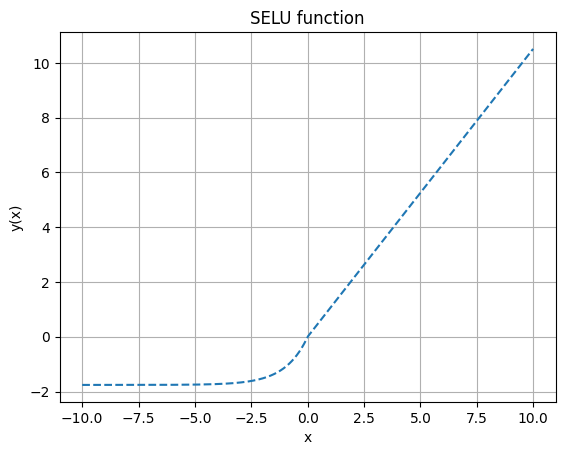

In [21]:
import matplotlib.pyplot as plt
from math import erfc, sqrt, exp, pi, e
import jax.numpy as jp
import jax
x_cpu = np.linspace(-10.0, 10.0, 10_000_000)


alpha =  - sqrt(2.0 / pi) / (erfc(1 / sqrt(2)) * exp(1/2) - 1)
scale = (
    (1 - erfc(1 / sqrt(2)) * sqrt(e)) * sqrt(2 * pi) / 
    sqrt(2 * erfc(sqrt(2)) * e ** 2 + pi * e * erfc(1/sqrt(2)) ** 2 
         - 2 * (2 + pi)* erfc(1 / sqrt(2))*sqrt(e) + pi + 2)
)

def selu_cpu(x, a=alpha, l=scale):
    return np.where(x > 0, l * x, l * (a * np.exp(x) - a))

def selu_gpu(x, a=alpha, l=scale):
    return jp.where(x > 0, l * x, l * (a * jp.exp(x) - a))

print('SELU Cpu: ', end='')
with cpu_timer():
    s_cpu = selu_cpu(x_cpu)
    
x_gpu = jax.device_put(x_cpu).block_until_ready()

print('SELU Gpu: ', end='')
with cpu_timer():
    s_gpu = selu_gpu(x_cpu).block_until_ready()

# Similar Functinality with cupy
'''
import cupy as cp
#x_gpu = cp.array(x_cpu)
selu_kernel = cp.ElementwiseKernel(
    'float64 X, float64 a, float64 l',
    'float64 selu',
    f'selu = X > 0 ? l * X : l * (a * exp(X) - a);', 
    'selu_kernel')
    
@cp.fuse
def selu_fused(x, a=alpha, l=scale):
    return cp.where(x > 0, l * x, l * (a * cp.exp(x) - a))

print('SELU Cpu: ', end='')
with cpu_timer():
    s_cpu = selu_cpu(x_cpu)
    
print('SELU Fused: ', end='')
with cupy_timer():
    s_gpu_fused = selu_fused(x_gpu)
    
print('SELU Kernel: ', end='')
with cupy_timer():
    s_gpu_kernel = selu_kernel(x_gpu, alpha, scale)
    
assert(np.allclose(s_cpu, s_gpu_fused.get()))
'''

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_cpu, s_cpu, '--');
ax.set_title('SELU function', )
ax.set_xlabel('x')
ax.set_ylabel('y(x)')
ax.grid('Both');

### (Exercise) Do the same with JAX and measure the performance

#### Using Gradient computation with `JAX`

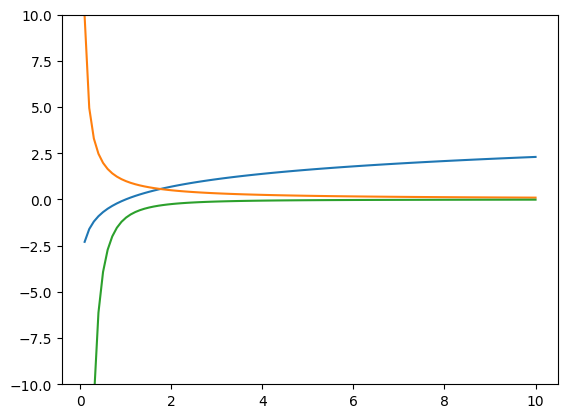

In [27]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

def fun1(x):
    return jnp.log(x)

x = jnp.linspace(0, 10, 100)
y = fun1(x)

y1 = jax.grad(fun1)
y2 = jax.grad(y1)

plt.ylim(-10, 10)
plt.plot(x, y)
plt.plot(x, jax.vmap(y1)(x))
plt.plot(x, jax.vmap(y2)(x))